# ETL pipeline for Text Mining and Analytics

In this experiment you will:

* perform text mining and analytics using Spark SQL functions
* use Spark’s built-in and external data sources to write data in different file formats as part of the extract, transform, and load (ETL) tasks


## Information

The basic terminology related to text analytics are

* **Text**: a sequence of words and punctuation
* **Corpus**: a large body of text
* **Frequency distribution**: the frequency of words in a text object
* **Collocation**: a sequence of words that occur together unusually often
* **Bigrams**: word pairs. High frequent bigrams are collocations
* **Text normalization**: the process of transforming text into a single canonical form, e.g., converting text to lowercase, removing punctuations and stop words.

### Introduction

Text analytics is the process of deriving information from text. It usually involves information retrieval, lexical analysis to study word frequency distributions, pattern recognition, tagging, information extraction, visualization, and predictive analytics. The overarching goal is, essentially, to turn text into data for analysis, via application of natural language processing (NLP), different types of algorithms and analytical methods.

Here we will consider `milton-paradise.txt` text file from Gutenberg corpus to do text mining and analytics. Starting from data extraction, we will perform various transformations on text including tokenization, the number of words counting, POS tagging, chunking and then store it in different file formats.

In [ ]:
#!pip install pyspark

### Import required packages

In [1]:
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import pandas as pd
import string
from pyspark.ml.feature import NGram
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.sql.functions import *
import nltk

### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. Instead of having various context, everything is now encapsulated in a Spark session.

In [2]:
# Start spark session
spark = SparkSession.builder.appName('ETL text data').getOrCreate()
spark

### Text Analytics

#### Get the text data

The raw text is from the Gutenberg corpus from the nltk package. Get file ids in Gutenberg corpus.

In [3]:
nltk.download('gutenberg')

# Download dependencies for sent_tokenize()
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\vidyadhar\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vidyadhar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from nltk.corpus import gutenberg
gutenberg_fileids = gutenberg.fileids()
gutenberg_fileids

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

The file id is `milton-paradise.txt`. Use the nltk.sent_tokenize() function to split text into sentences.

In [5]:
milton_paradise = gutenberg.raw('milton-paradise.txt')

pdf = pd.DataFrame({'sentences': nltk.sent_tokenize(milton_paradise)})
d = spark.createDataFrame(pdf)
d.show(1, truncate= False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                                         

From above it can be seen that empty spaces are present in the data.

#### Transform Data

* Remove trailing spaces

In [6]:
# Transform data
d1 = d.withColumn("sentences", regexp_replace(col("sentences"), "\\s+","_"))       # replace all spaces with underscore
d1 = d1.withColumn("sentences", regexp_replace(col("sentences"), "_"," "))         # replace all underscores with one space
d1 = d1.withColumn("sentences", trim(col("sentences")))                            # remove trailing spaces

In [7]:
d1.show(5, truncate= False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentences                                                                                                                                                                                                                                                                                  

In [8]:
# Check for empty lines
d1.where(col("sentences")=="").count()

0

In [9]:
from nltk.tokenize import word_tokenize

word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
d2 = d1.withColumn("words", word_udf("sentences"))

In [11]:
d2.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

From above it can be seen that data has punctuations in it.

* **Remove punctuation and stopwords**

In [12]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vidyadhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'my', 'her', 'below', 'then', 'over', 'your', 'too', 'those', 'for', 'himself', 'again', "needn't", 'by', 'yourselves', "shan't", 'through', 'weren', 'isn', 'herself', 'o', 'needn', 'should', 'nor', 'are', 'other', 'was', 'when', 'after', 't', 'she', "mustn't", 'further', "couldn't", 'having', 'their', 'how', 'whom', 'just', 'against', 'under', 'few', 'no', 'about', 'be', 'he', 'i', "you're", 'that', 'the', 'during', 'you', 'this', 'very', 'hasn', 'being', 'on', 'before', 'down', 'each', 'ourselves', 'hadn', 'our', 'd', 'into', 'or', 'been', 'itself', 'from', 'couldn', 'own', "didn't", 'of', "should've", 'an', 'them', "wasn't", 'wouldn', 'out', 'y', 'haven', 'mustn', "weren't", 'doesn', 'myself', 'once', 'who', 'can', 'theirs', 'shouldn', 'only', "won't", 'doing', 'has', 'in', 'to', 'mightn', 'do', 'did', 'what', 'until', 'why', 'its', "it's", 'more', 'because', "doesn't", 'me', 'not', "isn't", "shouldn't", 'up', 'have', 'we', 'am', 'm', 'ma', 's', 've', 'a', 'his', 'while', 'ain', 'w

In [14]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [16]:
# Transform data
punct_udf = udf(lambda x: [w for w in x if not w in punctuation if not w in stop_words])
d3 = d2.withColumn("words", punct_udf("words"))
d3.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
d3.dtypes

[('sentences', 'string'), ('words', 'string')]

In [18]:
# Convert dataframe column to arraytype for further processing

array_udf = udf(lambda x: x, ArrayType(StringType()))
d4 = d3.withColumn("words", array_udf("words"))
d4.show(5)

+--------------------+--------------------+
|           sentences|               words|
+--------------------+--------------------+
|[Paradise Lost by...|[Paradise, Lost, ...|
|And chiefly thou,...|[And, chiefly, th...|
|Say first--for He...|[Say, first, --, ...|
|Who first seduced...|[Who, first, sedu...|
|Th' infernal Serp...|[Th, infernal, Se...|
+--------------------+--------------------+
only showing top 5 rows



In [19]:
d4.dtypes

[('sentences', 'string'), ('words', 'array<string>')]

##### Ngrams and collocations

Collocation is a sequence of words that occur together unusually often.
Bigrams: word pairs. High frequent bigrams are collocations.

Let's see how we transform texts to 2-grams, 3-grams, and 4-grams collocations.

In [20]:
ngrams = [NGram(n=n, inputCol='words', outputCol=str(n)+'-grams') for n in [2,3,4]]

# build pipeline model
pipeline = Pipeline(stages=ngrams)

# transform data
texts_ngrams = pipeline.fit(d4).transform(d4)

In [21]:
# display result
texts_ngrams.select('2-grams').show(6, truncate=False)
texts_ngrams.select('3-grams').show(6, truncate=False)
texts_ngrams.select('4-grams').show(6, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* Add the number of words column

In [22]:
# Transform data
len_udf = udf(lambda x: len(x), IntegerType())

d5 = d4.withColumn("no_of_words", len_udf("words"))

In [23]:
d5.show(5)

+--------------------+--------------------+-----------+
|           sentences|               words|no_of_words|
+--------------------+--------------------+-----------+
|[Paradise Lost by...|[Paradise, Lost, ...|         90|
|And chiefly thou,...|[And, chiefly, th...|         50|
|Say first--for He...|[Say, first, --, ...|         34|
|Who first seduced...|[Who, first, sedu...|          5|
|Th' infernal Serp...|[Th, infernal, Se...|         50|
+--------------------+--------------------+-----------+
only showing top 5 rows



##### **POS (part-of-speech) tagging**

It is a process of converting a sentence to forms – list of words, list of tuples (where each tuple is having a form (word, tag)). The tag is a part-of-speech tag and signifies whether the word is a noun, adjective, verb, and so on.

To know more about POS tagging click [here](https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb).

In [24]:
# Download dependencies for pos_tag()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vidyadhar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
## define schema for returned result from the udf function
## the returned result is a list of tuples
schema = ArrayType(StructType([
            StructField('f1', StringType()),
            StructField('f2', StringType())    ]))

sent_to_tag_words_udf = udf(lambda x: nltk.pos_tag(x), schema)

In [27]:
# Transform data
d6 = d5.withColumn("tagged_words", sent_to_tag_words_udf("words"))
d6.select(['tagged_words']).show(5, truncate=False) 

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### **Frequency Distribution Plot**

It gives us information about the number of times a word has occurred within a sentence.

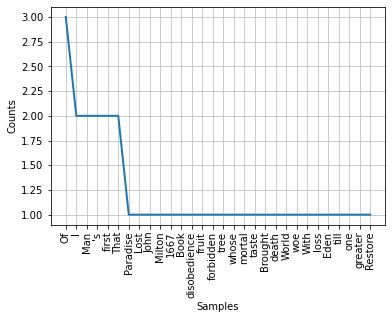

In [28]:
from nltk.probability import FreqDist

row = d6.select('words').toPandas().iloc[0,0]
fd = FreqDist(row) 
fd.plot(30, cumulative= False)
plt.show()

From the above plot it can be seen that in the first row, the word 'Man' has occurred twice.

##### **Chunking**
Chunking is the process of grouping similar words together based on the nature of the word. It is the process of segmenting and labeling multitokens. Let's see how to do a noun phrase chunking on the tagged words data frame from the previous step.

First we need to define a udf function that chunks noun phrases from a list of pos-tagged words.

In [29]:
# define a udf function to chunk noun phrases from pos-tagged words
grammar = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(grammar)
chunk_parser_udf = udf(lambda x: str(chunk_parser.parse(x)), StringType())

In [30]:
# Transform data
d7 = d6.withColumn("NP_chunk", chunk_parser_udf("tagged_words"))

In [31]:
d7.select('NP_chunk').show(1, truncate= False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Load data

**Use Parquet file to store data**

In [32]:
d7.write.format("parquet").mode("overwrite").save("transformed_text_parquet_data")

**Read data from Parquet file**

In [33]:
df_text_parquet = spark.read.format("parquet").load("transformed_text_parquet_data")

In [40]:
df_text_parquet.toPandas()

,sentences,words,no_of_words,tagged_words,NP_chunk
0,"He said, and on his Son with rays direct Shone...","[He, said, Son, rays, direct, Shone, full, Fat...",19,"[(He, PRP), (said, VBD), (Son, NNP), (rays, NN...",(S\n He/PRP\n said/VBD\n Son/NNP\n rays/NN...
1,"O Father, O Supreme of heavenly Thrones, First...","[O, Father, O, Supreme, heavenly, Thrones, Fir...",38,"[(O, NNP), (Father, NNP), (O, NNP), (Supreme, ...",(S\n O/NNP\n Father/NNP\n O/NNP\n Supreme/...
2,"Scepter and power, thy giving, I assume, And g...","[Scepter, power, thy, giving, I, assume, And, ...",61,"[(Scepter, NNP), (power, NN), (thy, IN), (givi...",(S\n Scepter/NNP\n (NP power/NN)\n thy/IN\n...
3,"Then shall thy Saints unmixed, and from the im...","[Then, shall, thy, Saints, unmixed, impure, Fa...",22,"[(Then, RB), (shall, MD), (thy, VB), (Saints, ...",(S\n Then/RB\n shall/MD\n thy/VB\n Saints/...
4,"So said, he, o'er his scepter bowing, rose Fro...","[So, said, o'er, scepter, bowing, rose, From, ...",19,"[(So, RB), (said, VBD), (o'er, JJ), (scepter, ...",(S\n So/RB\n said/VBD\n (NP o'er/JJ scepter...
...,...,...,...,...,...
1830,O!,[O],1,"[(O, NN)]",(S (NP O/NN))
1831,might I here In solitude live savage; in some ...,"[might, I, In, solitude, live, savage, glade, ...",23,"[(might, MD), (I, PRP), (In, IN), (solitude, N...",(S\n might/MD\n I/PRP\n In/IN\n (NP solitu...
1832,"Ye Cedars, with innumerable boughs Hide me, wh...","[Ye, Cedars, innumerable, boughs, Hide, I, may...",55,"[(Ye, NNP), (Cedars, NNP), (innumerable, JJ), ...",(S\n Ye/NNP\n Cedars/NNP\n innumerable/JJ\n...
1833,"So counselled he, and both together went Into ...","[So, counselled, together, went, Into, thickes...",80,"[(So, RB), (counselled, VBN), (together, RB), ...",(S\n So/RB\n counselled/VBN\n together/RB\n...


**Store the data as a `json file`**

In [35]:
d7.write.format("json").mode("overwrite").save('transformed_text_json_data.json')

**Read data from `json` to spark dataframe**

In [36]:
df_text_json = spark.read.format("json").load('transformed_text_json_data.json')

In [41]:
df_text_json.toPandas()

,NP_chunk,no_of_words,sentences,tagged_words,words
0,(S\n He/PRP\n said/VBD\n Son/NNP\n rays/NN...,19,"He said, and on his Son with rays direct Shone...","[(He, PRP), (said, VBD), (Son, NNP), (rays, NN...","[He, said, Son, rays, direct, Shone, full, Fat..."
1,(S\n O/NNP\n Father/NNP\n O/NNP\n Supreme/...,38,"O Father, O Supreme of heavenly Thrones, First...","[(O, NNP), (Father, NNP), (O, NNP), (Supreme, ...","[O, Father, O, Supreme, heavenly, Thrones, Fir..."
2,(S\n Scepter/NNP\n (NP power/NN)\n thy/IN\n...,61,"Scepter and power, thy giving, I assume, And g...","[(Scepter, NNP), (power, NN), (thy, IN), (givi...","[Scepter, power, thy, giving, I, assume, And, ..."
3,(S\n Then/RB\n shall/MD\n thy/VB\n Saints/...,22,"Then shall thy Saints unmixed, and from the im...","[(Then, RB), (shall, MD), (thy, VB), (Saints, ...","[Then, shall, thy, Saints, unmixed, impure, Fa..."
4,(S\n So/RB\n said/VBD\n (NP o'er/JJ scepter...,19,"So said, he, o'er his scepter bowing, rose Fro...","[(So, RB), (said, VBD), (o'er, JJ), (scepter, ...","[So, said, o'er, scepter, bowing, rose, From, ..."
...,...,...,...,...,...
1830,(S (NP O/NN)),1,O!,"[(O, NN)]",[O]
1831,(S\n might/MD\n I/PRP\n In/IN\n (NP solitu...,23,might I here In solitude live savage; in some ...,"[(might, MD), (I, PRP), (In, IN), (solitude, N...","[might, I, In, solitude, live, savage, glade, ..."
1832,(S\n Ye/NNP\n Cedars/NNP\n innumerable/JJ\n...,55,"Ye Cedars, with innumerable boughs Hide me, wh...","[(Ye, NNP), (Cedars, NNP), (innumerable, JJ), ...","[Ye, Cedars, innumerable, boughs, Hide, I, may..."
1833,(S\n So/RB\n counselled/VBN\n together/RB\n...,80,"So counselled he, and both together went Into ...","[(So, RB), (counselled, VBN), (together, RB), ...","[So, counselled, together, went, Into, thickes..."
